# 环境

  为实验安装需要用到的库

In [ ]:
# !pip install datasets
# !pip install factor_analyzer
# !pip install xlwt
# !pip install seaborn
# !pip install collection

# 准备数据

In [ ]:
from datasets import load_dataset

dataset = load_dataset('imdb')

print(len(dataset['train']), len(dataset['test']), len(dataset['unsupervised']))
print(dataset['train'][0])

# 训练词向量

  首先预处理文本，分词和去除标点符号。

In [ ]:
# 对于每一段评论文本，去除标点符号和换行符，单词间空格相连
# 需注意，当前处理方法没有把单词中的标点符号去掉
def no_space(char, prev_char):
    return char in set(',.!?') and prev_char != ' ' and ord(prev_char) >= 97


def preprocess(sentence):
    sentence = sentence.strip('\n').replace('<br /><br />', ' ').replace('(', '').replace(')', '')
    out = [' ' + char if i > 0 and no_space(char, sentence[i - 1]) else char
        for i, char in enumerate(sentence)]
    return ''.join(out)


processed = []
for onedata in dataset['train']:
    processed.append(preprocess(onedata['text']))

print(processed[0])

In [ ]:
punc = set(',.?!')
words = [[word for word in sen.split(' ') if word not in punc] for sen in processed]
len(words), len(words[0])

In [ ]:
[
[token1, token2, ..., ...], 
[]
]

In [ ]:
# 训练词向量
from gensim.models import word2vec

file_path = 'autodl-tmp/' # 这个文件夹用来保存和读取文件，速度比较快 
model = word2vec.Word2Vec(sentences=words, vector_size=512, sg=1, min_count=5)

In [ ]:
model.save(file_path + "imdb_word_vec_sg.bin")

# 因子分析

In [ ]:
import numpy as np
import pandas as pd
from d2l import torch as d2l
import matplotlib.pyplot as plt
import seaborn as sns
import math
from gensim.models import word2vec
from factor_analyzer import FactorAnalyzer

In [ ]:
# 加载训练好的word2vec模型
model = word2vec.Word2Vec.load(file_path + 'imdb_word_vec_sg.bin')
embedding = np.array([model.wv[word] for word in model.wv.index_to_key])
print(embedding.shape)

# 查看单词的词向量
model.wv['fascinating']

  百度搜“python因子分析”，相关的代码教程不少，也很简单易懂。

In [ ]:
# Bartlett's球状检验
print('Bartlett\'s球状检验: 检验总体变量的相关矩阵是否是单位阵')
chi_square_value, p_value = calculate_bartlett_sphericity(embedding)
print(chi_square_value, p_value)

# 导入kmo检验
print('kmo检验:')
print('检查变量间的相关性和偏相关性，取值在0-1之间；KMO统计量越接近1，变量间的相关性越强，偏相关性越弱，因子分析的效果越好')
kmo_all, kmo_model = calculate_kmo(embedding)
print('KMO值为: ', kmo_model)

In [ ]:
# 因子分析
fa = FactorAnalyzer(25, rotation=None)
# fa = FactorAnalyzer(25, rotation='varimax')
fa.fit(embedding)

# 特征值、特征向量
ev, v = fa.get_eigenvalues()

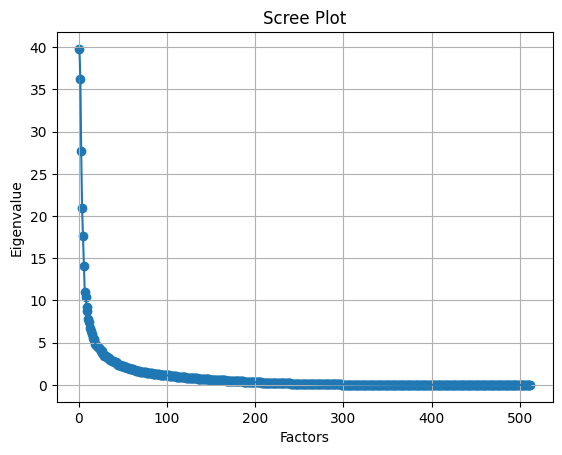

In [7]:
# 可视化
# plot横轴是指标个数，纵轴是ev值
plt.scatter(range(1, embedding.shape[1]+1), ev)
plt.plot(range(1, embedding.shape[1]+1), ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

# plt.savefig('ev.png')

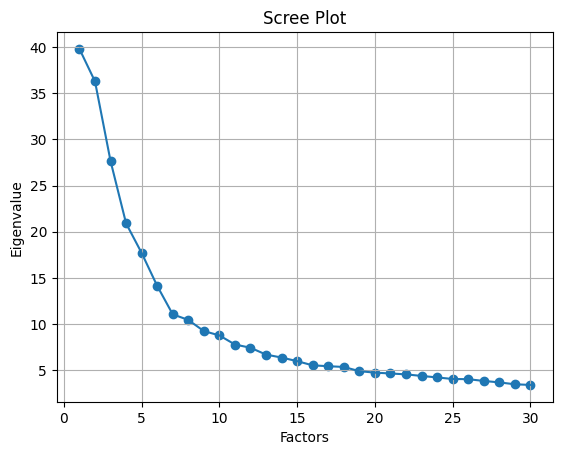

<Figure size 640x480 with 0 Axes>

In [8]:
# 更清晰的展示前三十个
plt.scatter(range(1, 31), ev[:30])
plt.plot(range(1, 31), ev[:30])
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()
plt.savefig(file_path + 'ev30.png')

In [11]:
# 上图表示，八个因子已经承载了足够多的特征值，确定因子数为8进行因子分析
fa = FactorAnalyzer(8, rotation="promax")
fa.fit(embedding)
print(fa.loadings_.shape)

# 保存因子分析的结果
# 512*8(变量个数*因子个数)
index = fa.loadings_.argmax(axis=1)
res = np.array([[i, idx] for i, idx in enumerate(index)])

data_1 = pd.DataFrame(fa.loadings_, columns=['fa1', 'fa2', 'fa3', 'fa4', 'fa5', 'fa6', 'fa7', 'fa8'])
data_2 = pd.DataFrame(res, columns=['Dimension', 'Factor'])
with pd.ExcelWriter(file_path + "FA.xls") as writer1:
    data_1.to_excel(writer1, sheet_name="Sheet1")
    data_2.to_excel(writer1, sheet_name="Sheet2")
    writer1.save()

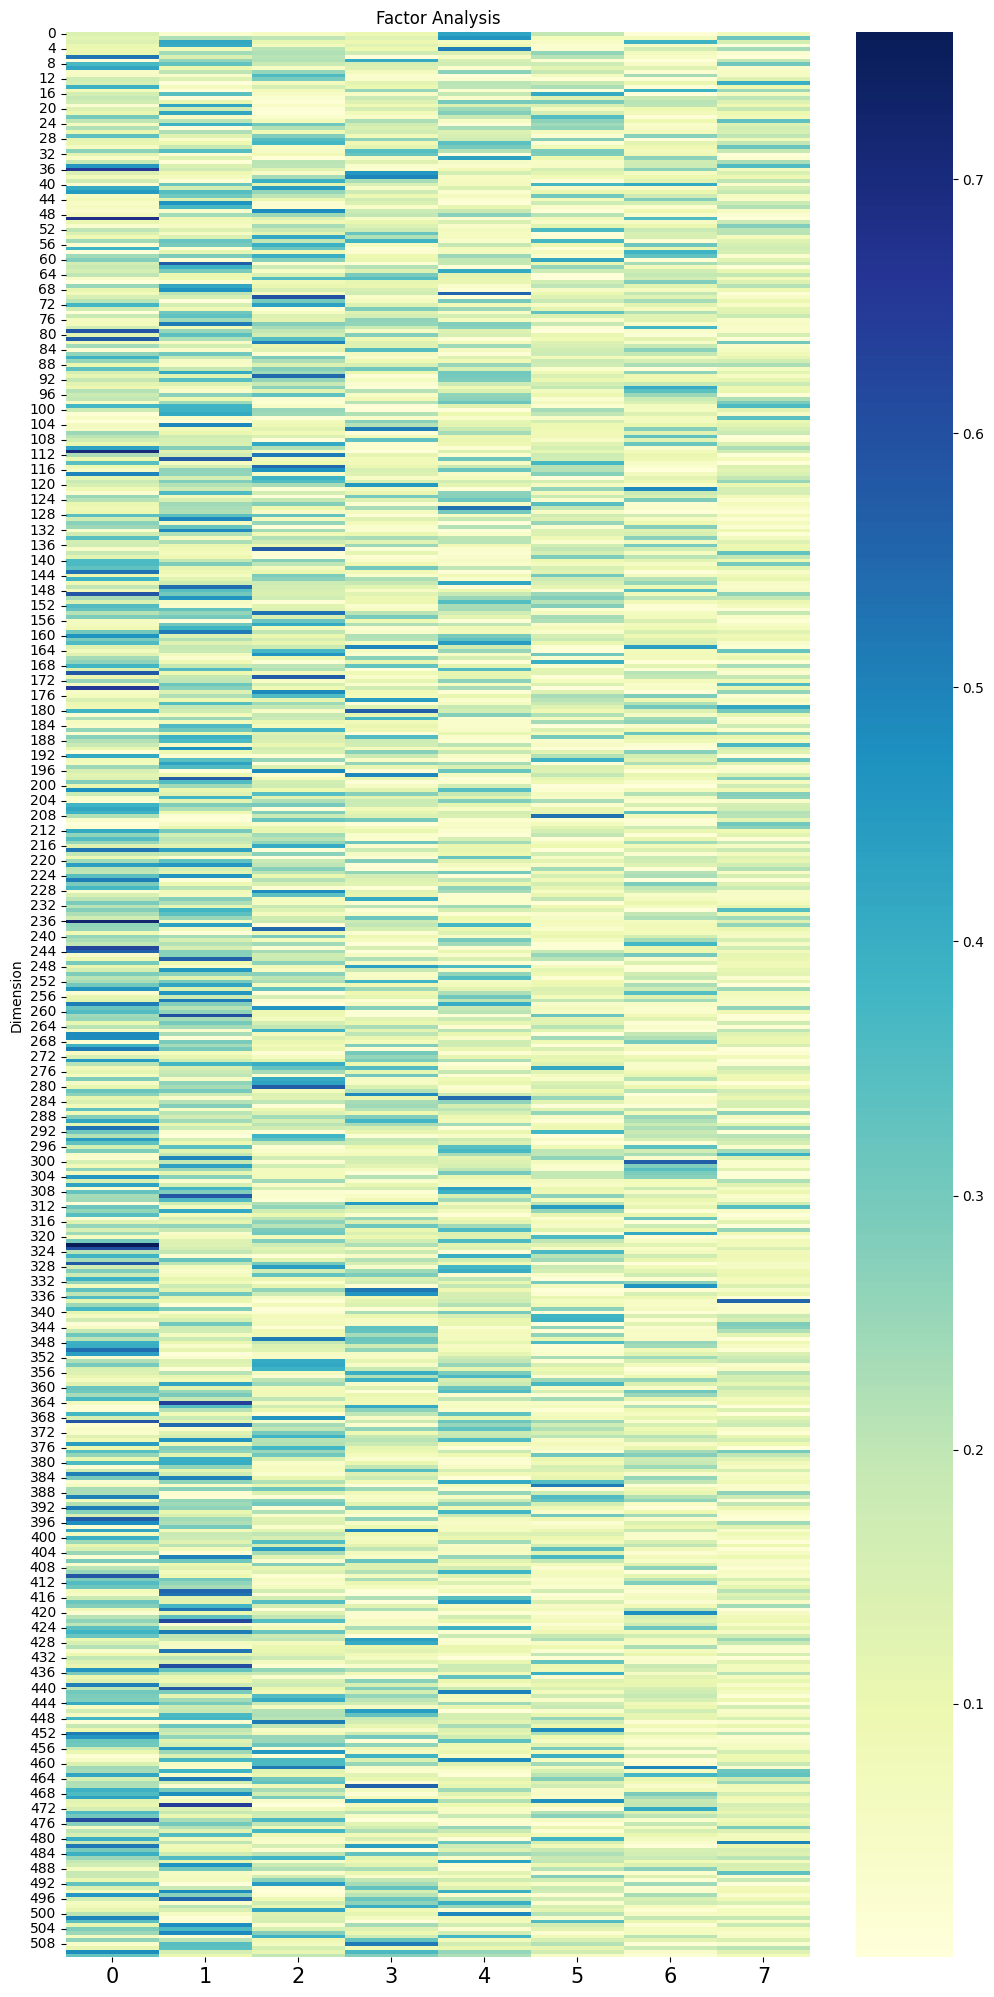

In [18]:
# 因子分析结果可视化
df_cm = pd.DataFrame(np.abs(fa.loadings_))
fig,ax = plt.subplots(figsize=(12,25))
sns.heatmap(df_cm, annot = None, cmap='YlGnBu',ax=ax)  # cbar_kws

ax.tick_params(axis='x',labelsize=15)
ax.set_title("Factor Analysis",fontsize=12)
ax.set_ylabel("Dimension")
plt.savefig(file_path + 'dimension.png')

# 模型架构

In [1]:
# 做完因子分析得到结果后，接下来的模型构建和训练和前面关系不大了
# 每次引用下面这些库就足够
import torch
from torch import nn
import numpy as np
import pandas as pd
from d2l import torch as d2l
import matplotlib.pyplot as plt
from datasets import load_dataset
from tqdm import tqdm
import time
import math
from gensim.models import word2vec

In [2]:
class FAMAttention(nn.Module):
    """修改多头注意力，针对嵌入512维，8个head的模型"""

    def __init__(self, num_hiddens, dim_dict, dropout, bias=False, **kwargs):
        super(FlexiHeadAttention, self).__init__(**kwargs)
        self.attention = d2l.DotProductAttention(dropout)
        self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=bias)
        self.dim_dict = dim_dict
        self.dim_0 = [dim for dim, idx in self.dim_dict.items() if idx == 0]
        self.dim_1 = [dim for dim, idx in self.dim_dict.items() if idx == 1]
        self.dim_2 = [dim for dim, idx in self.dim_dict.items() if idx == 2]
        self.dim_3 = [dim for dim, idx in self.dim_dict.items() if idx == 3]
        self.dim_4 = [dim for dim, idx in self.dim_dict.items() if idx == 4]
        self.dim_5 = [dim for dim, idx in self.dim_dict.items() if idx == 5]
        self.dim_6 = [dim for dim, idx in self.dim_dict.items() if idx == 6]
        self.dim_7 = [dim for dim, idx in self.dim_dict.items() if idx == 7]
        # self.list_concat = torch.cat((self.dim_0, self.dim_1, self.dim_2, self.dim_3, self.dim_4, self.dim_5,
        # self.dim_6, self.dim_7))
        self.len_0, self.len_1, self.len_2, self.len_3, self.len_4, self.len_5, self.len_6, self.len_7 = len(
            self.dim_0), len(self.dim_1), len(self.dim_2), len(self.dim_3), len(self.dim_4), len(self.dim_5),\
            len(self.dim_6), len(self.dim_7)

        self.Wq0 = nn.Linear(self.len_0, self.len_0, bias=bias)
        self.Wq1 = nn.Linear(self.len_1, self.len_1, bias=bias)
        self.Wq2 = nn.Linear(self.len_2, self.len_2, bias=bias)
        self.Wq3 = nn.Linear(self.len_3, self.len_3, bias=bias)
        self.Wq4 = nn.Linear(self.len_4, self.len_4, bias=bias)
        self.Wq5 = nn.Linear(self.len_5, self.len_5, bias=bias)
        self.Wq6 = nn.Linear(self.len_6, self.len_6, bias=bias)
        self.Wq7 = nn.Linear(self.len_7, self.len_7, bias=bias)

        self.Wk0 = nn.Linear(self.len_0, self.len_0, bias=bias)
        self.Wk1 = nn.Linear(self.len_1, self.len_1, bias=bias)
        self.Wk2 = nn.Linear(self.len_2, self.len_2, bias=bias)
        self.Wk3 = nn.Linear(self.len_3, self.len_3, bias=bias)
        self.Wk4 = nn.Linear(self.len_4, self.len_4, bias=bias)
        self.Wk5 = nn.Linear(self.len_5, self.len_5, bias=bias)
        self.Wk6 = nn.Linear(self.len_6, self.len_6, bias=bias)
        self.Wk7 = nn.Linear(self.len_7, self.len_7, bias=bias)

        self.Wv0 = nn.Linear(self.len_0, self.len_0, bias=bias)
        self.Wv1 = nn.Linear(self.len_1, self.len_1, bias=bias)
        self.Wv2 = nn.Linear(self.len_2, self.len_2, bias=bias)
        self.Wv3 = nn.Linear(self.len_3, self.len_3, bias=bias)
        self.Wv4 = nn.Linear(self.len_4, self.len_4, bias=bias)
        self.Wv5 = nn.Linear(self.len_5, self.len_5, bias=bias)
        self.Wv6 = nn.Linear(self.len_6, self.len_6, bias=bias)
        self.Wv7 = nn.Linear(self.len_7, self.len_7, bias=bias)

    def forward(self, queries, keys, values, valid_lens):
        def assemble(output_concat, list_concat):
            reslist = []
            for i in range(512):
                reslist.append(list_concat.index(i))
            return torch.index_select(output_concat, -1, torch.tensor(reslist, device=output_concat.device))

        # queries, keys, values的形状: (batch_size，查询或者“键－值”对的个数，num_hiddens)
        # qi, ki, vi的形状：(batch_size, 查询或者“键－值”对的个数， self.len_i)
        q0, k0, v0 = torch.index_select(queries, -1, torch.tensor(self.dim_0, device=queries.device)), \
            torch.index_select(keys, -1, torch.tensor(self.dim_0, device=keys.device)), torch.index_select(
            values, -1, torch.tensor(self.dim_0, device=values.device))
        q1, k1, v1 = torch.index_select(queries, -1, torch.tensor(self.dim_1, device=queries.device)), \
            torch.index_select(keys, -1, torch.tensor(self.dim_1, device=keys.device)), torch.index_select(
            values, -1, torch.tensor(self.dim_1, device=values.device))
        q2, k2, v2 = torch.index_select(queries, -1, torch.tensor(self.dim_2, device=queries.device)), \
            torch.index_select(keys, -1, torch.tensor(self.dim_2, device=keys.device)), torch.index_select(
            values, -1, torch.tensor(self.dim_2, device=values.device))
        q3, k3, v3 = torch.index_select(queries, -1, torch.tensor(self.dim_3, device=queries.device)), \
            torch.index_select(keys, -1, torch.tensor(self.dim_3, device=keys.device)), torch.index_select(
            values, -1, torch.tensor(self.dim_3, device=values.device))
        q4, k4, v4 = torch.index_select(queries, -1, torch.tensor(self.dim_4, device=queries.device)), \
            torch.index_select(keys, -1, torch.tensor(self.dim_4, device=keys.device)), torch.index_select(
            values, -1, torch.tensor(self.dim_4, device=values.device))
        q5, k5, v5 = torch.index_select(queries, -1, torch.tensor(self.dim_5, device=queries.device)), \
            torch.index_select(keys, -1, torch.tensor(self.dim_5, device=keys.device)), torch.index_select(
            values, -1, torch.tensor(self.dim_5, device=values.device))
        q6, k6, v6 = torch.index_select(queries, -1, torch.tensor(self.dim_6, device=queries.device)), \
            torch.index_select(keys, -1, torch.tensor(self.dim_6, device=keys.device)), torch.index_select(
            values, -1, torch.tensor(self.dim_6, device=values.device))
        q7, k7, v7 = torch.index_select(queries, -1, torch.tensor(self.dim_7, device=queries.device)), \
            torch.index_select(keys, -1, torch.tensor(self.dim_7, device=keys.device)), torch.index_select(
            values, -1, torch.tensor(self.dim_7, device=values.device))

        head0 = self.attention(self.Wq0(q0), self.Wk0(k0), self.Wv0(v0), valid_lens)
        head1 = self.attention(self.Wq1(q1), self.Wk1(k1), self.Wv1(v1), valid_lens)
        head2 = self.attention(self.Wq2(q2), self.Wk2(k2), self.Wv2(v2), valid_lens)
        head3 = self.attention(self.Wq3(q3), self.Wk3(k3), self.Wv3(v3), valid_lens)
        head4 = self.attention(self.Wq4(q4), self.Wk4(k4), self.Wv4(v4), valid_lens)
        head5 = self.attention(self.Wq5(q5), self.Wk5(k5), self.Wv5(v5), valid_lens)
        head6 = self.attention(self.Wq6(q6), self.Wk6(k6), self.Wv6(v6), valid_lens)
        head7 = self.attention(self.Wq7(q7), self.Wk7(k7), self.Wv7(v7), valid_lens)

        output_concat = torch.cat((head0, head1, head2, head3, head4, head5, head6, head7), dim=-1)
        list_concat = self.dim_0 + self.dim_1 + self.dim_2 + self.dim_3 + self.dim_4 + self.dim_5 + self.dim_6 + self.dim_7
        return self.W_o(assemble(output_concat, list_concat))

In [3]:
# 编码器块
class EncoderBlock(nn.Module):
    """修改的编码器块"""

    def __init__(self, num_hiddens, norm_shape, ffn_num_input,
                 ffn_num_hiddens, dim_dict, dropout, use_bias=False, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        self.attention = FAMAttention(num_hiddens, dim_dict, dropout, use_bias)
        self.addnorm1 = d2l.AddNorm(norm_shape, dropout)
        self.ffn = d2l.PositionWiseFFN(
            ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm2 = d2l.AddNorm(norm_shape, dropout)

    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

In [8]:
# 编码器
class FAMEncoder(d2l.Encoder):
    """修改的编码器"""

    def __init__(self, vocab_size, num_hiddens, norm_shape, ffn_num_input,
                 ffn_num_hiddens, dim_dict, num_layers, dropout, num_output,
                 use_bias=False, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        self.outhidden = nn.Sequential(
                                    nn.Linear(num_hiddens, num_hiddens),
                                    nn.ReLU())
        self.Dense = nn.Linear(num_hiddens, num_output)
        for i in range(num_layers):
            self.blks.add_module("block" + str(i),
                                 EncoderBlock(num_hiddens, norm_shape, ffn_num_input,
                                              ffn_num_hiddens, dim_dict, dropout, use_bias))

    def forward(self, X, valid_lens, *args):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[i] = blk.attention.attention.attention_weights
        # 取句首'cls'token的向量用于情感分类
        return self.Dense(self.outhidden(X[:, 0, :]))

# 加载训练数据

In [ ]:
# 生成词表
def load_datawords(dataset):
    processed = []
    for onedata in dataset:
        processed.append(preprocess(onedata['text']))

    punc = set(',.?!')
    words = [[word for word in sen.split(' ') if word not in punc] for sen in processed]
    return [['<cls>'] + line for line in words]


train_words = load_datawords(dataset['train'])
vocab = d2l.Vocab(train_words, min_freq=5, reserved_tokens=['<pad>', '<cls>'])
print('词表大小: ', len(vocab))
print('前50个token: ', vocab.idx_to_token[:50])

In [6]:
# 生成训练数据集、测试数据集
# 每条数据包括: (语句词元, 语句有效长度, 标签)
def load_imdb_data(datawords, vocab, dataset, batch_size, num_steps):
    data_tokens = torch.tensor([d2l.truncate_pad(
        vocab[line], num_steps, vocab['<pad>']) for line in datawords])
    valid_lens = (data_tokens != vocab['<pad>']).type(torch.int32).sum(1)
    labels = torch.tensor(dataset[:]['label'])
    return d2l.load_array((data_tokens, valid_lens, labels), batch_size)


batch_size, num_steps = 64, 500
train_iter = load_imdb_data(train_words, vocab, dataset['train'], batch_size, num_steps)
for X, valid_len, y in train_iter:
    print('X:', X.shape, ', y:', y.shape, ', valid_len:', valid_len.shape)
    break
print('小批量数目：', len(train_iter))


# 测试集
test_words = load_datawords(dataset['test'])

test_iter = load_imdb_data(test_words, vocab, dataset['test'], 64, 500)

X: torch.Size([64, 500]) , y: torch.Size([64]) , valid_len: torch.Size([64])
小批量数目： 391


# 模型训练

In [ ]:
# 参数和超参数
num_hiddens, num_layers, dropout, num_output = 512, 1, 0.1, 2
ffn_num_input, ffn_num_hiddens, num_heads, norm_shape = 512, 2048, 8, [512]
lr, num_epochs, device = 5e-5, 60, d2l.try_gpu()

In [ ]:
# 因子分析结果
excelfile = pd.read_excel(file_path + 'FA.xls', sheet_name='Sheet2', header=0, index_col=0)
dim_dict = dict()
for i in range(512):
    dim_dict[excelfile['Dimension'].values[i]] = excelfile['Factor'].values[i]

In [ ]:
# 实例化模型, 打印模型参数数量
net = FAMEncoder(
    len(vocab), num_hiddens, norm_shape,
    ffn_num_input, ffn_num_hiddens, dim_dict,
    num_layers,dropout, num_output)

# Find total parameters and trainable parameters
total_params = sum(p.numel() for p in net.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

In [ ]:
# 用word2vector训练的词向量来初始化embedding层模型权重
def get_embedding_weights(vocab, word2vecmodel, num_hiddens):
    wordlist = word2vecmodel.wv.index_to_key
    n = len(vocab)
    data = np.random.randn(n, num_hiddens)
    for i in range(n):
        word = vocab.idx_to_token[i]
        data[i] = np.array(word2vecmodel.wv[word]) if word in wordlist else data[i]
    return torch.tensor(data, dtype=torch.float32)


def init_embedding_weights(net, weights):
    for m in net.modules():
        if isinstance(m, nn.Embedding):
            m.weight.data = weights


word2vecmodel = word2vec.Word2Vec.load(file_path + 'imdb_word_vec_sg.bin')
weights = get_embedding_weights(vocab, word2vecmodel, num_hiddens)
init_embedding_weights(net, weights)

In [ ]:
# 用Xavier初始化线性层权重
def xavier_init_weights(m):
    if type(m) in (nn.Linear, nn.Conv1d):
        nn.init.xavier_uniform_(m.weight)


net.apply(xavier_init_weights)

In [ ]:
# 定义评估模型在测试集上准确率的函数
def evaluate_accuracy_gpu(net, data_iter, device=None):
    """Compute the accuracy for a model on a dataset using a GPU."""
    net.eval()  # Set the model to evaluation mode
    if not device:
        device = next(iter(net.parameters())).device
    # No. of correct predictions, no. of predictions
    metric = d2l.Accumulator(2)

    with torch.no_grad():
        for data in data_iter:
            if isinstance(data, list) or isinstance(data, tuple):
                X, valid_len, y = [x.to(device) for x in data]
            else:
                X = X.to(device)
            metric.add(d2l.accuracy(net(X, valid_len), y), d2l.size(y))
    return metric[0] / metric[1]

  由于模型的embedding层用word2vec词向量进行了初始化，可以认为嵌入层现在已经有了一定的信息表征能力，因此在接下来的训练过程里，给该层的参数一个较小的学习率，而给其他层更大的学习率(这里用的10倍)。已有的训练结果表示这样的微调方法产生的结果是不错的，但是不否认有更好的训练方式。

In [27]:
# 以‘微调’的模式进行训练
# activation function: nn.ReLU()
# 24,492,514 total parameters.
loss = nn.CrossEntropyLoss(reduction='none')
# 为不同层赋予不同的学习率
forward_params = [
    param for name, param in net.named_parameters()
    if name != "embedding.weight"]
trainer = torch.optim.Adam(
    [{'params': net.embedding.parameters()},
    {'params': forward_params,
    'lr': lr * 10}], lr=lr)
net.to(device)

num_batches = len(train_iter)
losses, train_accuracy, test_accuracy = [], [], []
total_start = time.time()
for epoch in range(num_epochs):
    train_loss, train_acc = 0, 0
    start_time = time.perf_counter()
    net.train()
    for index, data in tqdm(enumerate(train_iter), total=num_batches, leave = True):
        X, valid_len, y = [v.to(device) for v in data]
        l = loss(net(X, valid_len), y)
        trainer.zero_grad()
        l.sum().backward()
        trainer.step()
        train_loss += l.sum().cpu().detach().numpy() / batch_size
        train_acc += d2l.accuracy(net(X, valid_len), y) / batch_size
    epochloss, epochtrain, epochtest = train_loss / num_batches, train_acc / num_batches, evaluate_accuracy_gpu(net, test_iter)
    end_time = time.perf_counter()
    print(f'epoch {epoch + 1}, loss {epochloss:.3f}, train_acc {epochtrain:.3f}, '
         f'test_acc {epochtest:.3f}, taking {round(end_time - start_time)} seconds')
    losses.append(epochloss)
    train_accuracy.append(epochtrain)
    test_accuracy.append(epochtest)
total_timecost = round(time.time() - total_start)
print('Training is finished.')
print(f'训练损失:{losses[-1]:.3f}, 训练集准确率:{train_accuracy[-1]:.3f}, '
      f'测试集准确率:{test_accuracy[-1]:.3f}, '
     f'在设备{device}上训练{num_epochs}周期, 耗时{total_timecost} s')

100%|██████████| 391/391 [01:45<00:00,  3.72it/s]


epoch 1, loss 0.655, train_acc 0.622, test_acc 0.809, taking 133 seconds


100%|██████████| 391/391 [01:46<00:00,  3.69it/s]


epoch 2, loss 0.440, train_acc 0.804, test_acc 0.836, taking 134 seconds


100%|██████████| 391/391 [01:45<00:00,  3.71it/s]


epoch 3, loss 0.392, train_acc 0.830, test_acc 0.812, taking 133 seconds


100%|██████████| 391/391 [01:44<00:00,  3.75it/s]


epoch 4, loss 0.376, train_acc 0.841, test_acc 0.852, taking 132 seconds


100%|██████████| 391/391 [01:45<00:00,  3.72it/s]


epoch 5, loss 0.357, train_acc 0.849, test_acc 0.859, taking 133 seconds


100%|██████████| 391/391 [01:44<00:00,  3.74it/s]


epoch 6, loss 0.335, train_acc 0.860, test_acc 0.856, taking 132 seconds


100%|██████████| 391/391 [01:45<00:00,  3.71it/s]


epoch 7, loss 0.317, train_acc 0.870, test_acc 0.860, taking 133 seconds


100%|██████████| 391/391 [01:45<00:00,  3.72it/s]


epoch 8, loss 0.312, train_acc 0.870, test_acc 0.864, taking 133 seconds


100%|██████████| 391/391 [01:44<00:00,  3.73it/s]


epoch 9, loss 0.300, train_acc 0.877, test_acc 0.864, taking 132 seconds


100%|██████████| 391/391 [01:44<00:00,  3.73it/s]


epoch 10, loss 0.288, train_acc 0.884, test_acc 0.865, taking 132 seconds


100%|██████████| 391/391 [01:44<00:00,  3.74it/s]


epoch 11, loss 0.273, train_acc 0.886, test_acc 0.867, taking 132 seconds


100%|██████████| 391/391 [01:44<00:00,  3.74it/s]


epoch 12, loss 0.271, train_acc 0.892, test_acc 0.867, taking 132 seconds


100%|██████████| 391/391 [01:44<00:00,  3.75it/s]


epoch 13, loss 0.256, train_acc 0.900, test_acc 0.862, taking 132 seconds


100%|██████████| 391/391 [01:44<00:00,  3.73it/s]


epoch 14, loss 0.241, train_acc 0.905, test_acc 0.869, taking 132 seconds


100%|██████████| 391/391 [01:44<00:00,  3.75it/s]


epoch 15, loss 0.235, train_acc 0.909, test_acc 0.854, taking 132 seconds


100%|██████████| 391/391 [01:44<00:00,  3.75it/s]


epoch 16, loss 0.207, train_acc 0.920, test_acc 0.834, taking 132 seconds


100%|██████████| 391/391 [01:45<00:00,  3.70it/s]


epoch 17, loss 0.193, train_acc 0.925, test_acc 0.864, taking 133 seconds


100%|██████████| 391/391 [01:46<00:00,  3.69it/s]


epoch 18, loss 0.185, train_acc 0.931, test_acc 0.858, taking 134 seconds


100%|██████████| 391/391 [01:44<00:00,  3.74it/s]


epoch 19, loss 0.190, train_acc 0.928, test_acc 0.855, taking 132 seconds


100%|██████████| 391/391 [01:44<00:00,  3.73it/s]


epoch 20, loss 0.162, train_acc 0.940, test_acc 0.835, taking 132 seconds


100%|██████████| 391/391 [01:44<00:00,  3.75it/s]


epoch 21, loss 0.141, train_acc 0.949, test_acc 0.840, taking 132 seconds


100%|██████████| 391/391 [01:44<00:00,  3.74it/s]


epoch 22, loss 0.139, train_acc 0.949, test_acc 0.856, taking 132 seconds


100%|██████████| 391/391 [01:44<00:00,  3.76it/s]


epoch 23, loss 0.128, train_acc 0.953, test_acc 0.853, taking 132 seconds


100%|██████████| 391/391 [01:45<00:00,  3.72it/s]


epoch 24, loss 0.117, train_acc 0.957, test_acc 0.843, taking 133 seconds


100%|██████████| 391/391 [01:44<00:00,  3.73it/s]


epoch 25, loss 0.109, train_acc 0.961, test_acc 0.828, taking 132 seconds


100%|██████████| 391/391 [01:45<00:00,  3.70it/s]


epoch 26, loss 0.103, train_acc 0.965, test_acc 0.846, taking 133 seconds


100%|██████████| 391/391 [01:46<00:00,  3.67it/s]


epoch 27, loss 0.095, train_acc 0.966, test_acc 0.825, taking 134 seconds


100%|██████████| 391/391 [01:44<00:00,  3.75it/s]


epoch 28, loss 0.089, train_acc 0.971, test_acc 0.835, taking 132 seconds


100%|██████████| 391/391 [01:44<00:00,  3.73it/s]


epoch 29, loss 0.082, train_acc 0.970, test_acc 0.844, taking 132 seconds


100%|██████████| 391/391 [01:44<00:00,  3.73it/s]


epoch 30, loss 0.080, train_acc 0.972, test_acc 0.833, taking 132 seconds


100%|██████████| 391/391 [01:46<00:00,  3.68it/s]


epoch 31, loss 0.077, train_acc 0.974, test_acc 0.842, taking 134 seconds


100%|██████████| 391/391 [01:44<00:00,  3.74it/s]


epoch 32, loss 0.071, train_acc 0.973, test_acc 0.820, taking 132 seconds


100%|██████████| 391/391 [01:44<00:00,  3.75it/s]


epoch 33, loss 0.064, train_acc 0.977, test_acc 0.826, taking 132 seconds


100%|██████████| 391/391 [01:44<00:00,  3.75it/s]


epoch 34, loss 0.063, train_acc 0.978, test_acc 0.843, taking 132 seconds


100%|██████████| 391/391 [01:44<00:00,  3.73it/s]


epoch 35, loss 0.058, train_acc 0.980, test_acc 0.830, taking 132 seconds


100%|██████████| 391/391 [01:44<00:00,  3.73it/s]


epoch 36, loss 0.057, train_acc 0.979, test_acc 0.828, taking 132 seconds


100%|██████████| 391/391 [01:44<00:00,  3.73it/s]


epoch 37, loss 0.054, train_acc 0.981, test_acc 0.819, taking 133 seconds


100%|██████████| 391/391 [01:45<00:00,  3.72it/s]


epoch 38, loss 0.051, train_acc 0.981, test_acc 0.839, taking 133 seconds


100%|██████████| 391/391 [01:44<00:00,  3.75it/s]


epoch 39, loss 0.055, train_acc 0.979, test_acc 0.830, taking 132 seconds


100%|██████████| 391/391 [01:44<00:00,  3.75it/s]


epoch 40, loss 0.047, train_acc 0.982, test_acc 0.816, taking 132 seconds


100%|██████████| 391/391 [01:44<00:00,  3.74it/s]


epoch 41, loss 0.047, train_acc 0.985, test_acc 0.827, taking 132 seconds


100%|██████████| 391/391 [01:44<00:00,  3.73it/s]


epoch 42, loss 0.042, train_acc 0.985, test_acc 0.818, taking 132 seconds


100%|██████████| 391/391 [01:46<00:00,  3.68it/s]


epoch 43, loss 0.050, train_acc 0.980, test_acc 0.821, taking 134 seconds


100%|██████████| 391/391 [01:46<00:00,  3.68it/s]


epoch 44, loss 0.041, train_acc 0.984, test_acc 0.802, taking 134 seconds


100%|██████████| 391/391 [01:45<00:00,  3.72it/s]


epoch 45, loss 0.044, train_acc 0.984, test_acc 0.835, taking 133 seconds


100%|██████████| 391/391 [01:45<00:00,  3.70it/s]


epoch 46, loss 0.039, train_acc 0.986, test_acc 0.831, taking 133 seconds


100%|██████████| 391/391 [01:44<00:00,  3.76it/s]


epoch 47, loss 0.036, train_acc 0.987, test_acc 0.822, taking 132 seconds


100%|██████████| 391/391 [01:44<00:00,  3.73it/s]


epoch 48, loss 0.037, train_acc 0.987, test_acc 0.797, taking 132 seconds


100%|██████████| 391/391 [01:44<00:00,  3.74it/s]


epoch 49, loss 0.034, train_acc 0.987, test_acc 0.828, taking 132 seconds


100%|██████████| 391/391 [01:44<00:00,  3.73it/s]


epoch 50, loss 0.035, train_acc 0.987, test_acc 0.827, taking 132 seconds


100%|██████████| 391/391 [01:44<00:00,  3.74it/s]


epoch 51, loss 0.027, train_acc 0.989, test_acc 0.819, taking 132 seconds


100%|██████████| 391/391 [01:45<00:00,  3.72it/s]


epoch 52, loss 0.031, train_acc 0.990, test_acc 0.835, taking 133 seconds


100%|██████████| 391/391 [01:43<00:00,  3.76it/s]


epoch 53, loss 0.026, train_acc 0.990, test_acc 0.828, taking 132 seconds


100%|██████████| 391/391 [01:45<00:00,  3.72it/s]


epoch 54, loss 0.028, train_acc 0.990, test_acc 0.838, taking 133 seconds


100%|██████████| 391/391 [01:45<00:00,  3.72it/s]


epoch 55, loss 0.028, train_acc 0.990, test_acc 0.817, taking 133 seconds


100%|██████████| 391/391 [01:44<00:00,  3.75it/s]


epoch 56, loss 0.024, train_acc 0.991, test_acc 0.819, taking 132 seconds


100%|██████████| 391/391 [01:45<00:00,  3.72it/s]


epoch 57, loss 0.026, train_acc 0.990, test_acc 0.824, taking 133 seconds


100%|██████████| 391/391 [01:45<00:00,  3.70it/s]


epoch 58, loss 0.027, train_acc 0.990, test_acc 0.811, taking 134 seconds


100%|██████████| 391/391 [01:44<00:00,  3.73it/s]


epoch 59, loss 0.023, train_acc 0.991, test_acc 0.812, taking 132 seconds


100%|██████████| 391/391 [01:46<00:00,  3.68it/s]


epoch 60, loss 0.021, train_acc 0.991, test_acc 0.807, taking 134 seconds
Training is finished.
训练损失:0.021, 训练集准确率:0.991, 测试集准确率:0.807 在设备cuda:0上训练60周期 耗时7953 s


  对于画图效果的调整，可以参考网站https://blog.csdn.net/weixin_43384257/article/details/115640104, https://blog.csdn.net/qq_41870157/article/details/104328111
网上matplotlib的教程很多。

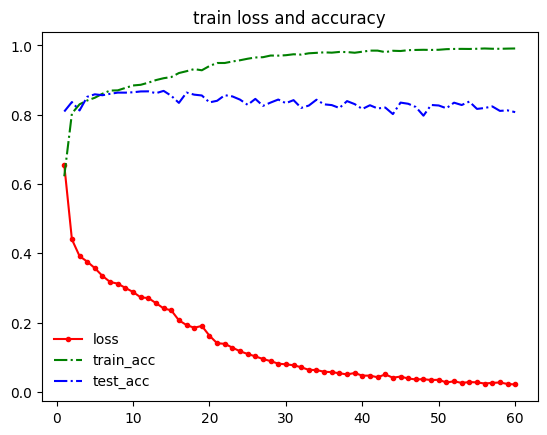

In [28]:
fig = plt.figure()
plt.title('train loss and accuracy')
epochs = np.arange(1, num_epochs + 1)
plt.axis([0, 60, 0, 1])
# losses, train_accuracy, test_accuracy
plt.plot(epochs, losses, 'r.-', label='loss')
plt.plot(epochs, train_accuracy, 'g-.', label='train_acc')
plt.plot(epochs, test_accuracy, 'b-.', label='test_acc')
plt.legend(loc='best', frameon=False)
plt.show()